In [2]:
import torch
import torch.nn as nn
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_style('whitegrid')

In [3]:
# make the original data
N = 1000
series = np.sin(0.1*np.arange(N)) #+ np.random.randn(N)*0.1

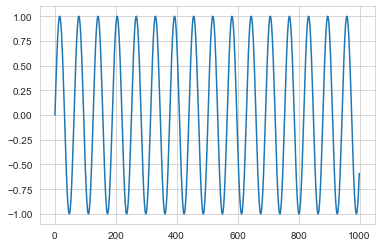

In [4]:
# plot it
plt.plot(series)

In [5]:
# Build the dataset
# T is used as past value to predict the next value
T = 10
X = []
Y = []
for t in range(len(series) - T):
    x = series[t:t+T]
    X.append(x)
    y = series[t+T]
    Y.append(y)
    
X = np.array(X).reshape(-1, T, 1)
Y = np.array(Y).reshape(-1, 1)
N = len(X)
print('X.shape:', X.shape, ' Y.shape:', Y.shape)

X.shape: (990, 10, 1)  Y.shape: (990, 1)


In [6]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [7]:
# DEFINE SimpleRNN
class SimpleRNN(nn.Module):
    def __init__(self, n_inputs, n_hidden, n_rnnlayers, n_outputs):
        super(SimpleRNN, self).__init__()
        self.D = n_inputs
        self.M = n_hidden
        self.K = n_outputs
        self.L = n_rnnlayers
        
        # note: batch_first=True
        # applies the convention that our data will be of shape: (num_samples, sequence_length, num_features)
        # rather than: (sequence_length, num_samples, num_features)
        self.rnn = nn.RNN(
            input_size = self.D,
            hidden_size = self.M,
            num_layers = self.L,
            nonlinearity = 'relu',
            batch_first = True)
        self.fc = nn.Linear(self.M, self.K)
        
    def forward(self, X):
        # initial hidden states
        h0 = torch.zeros(self.L, X.size(0), self.M).to(device)
        
        # get RNN unit output
        # out is of size (N, T, M)
        # 2nd return value is hidden states at each hidden layer, we don't need those now
        out, _ = self.rnn(X, h0)
        
        # we only want h(T) at the final time step
        # N x M => N x K
        out = self.fc(out[:, -1, :])
        return out

In [8]:
# Instantiate the model
model = SimpleRNN(n_inputs=1, n_hidden=5, n_rnnlayers=1, n_outputs=1)
model.to(device)

SimpleRNN(
  (rnn): RNN(1, 5, batch_first=True)
  (fc): Linear(in_features=5, out_features=1, bias=True)
)

In [9]:
# Loss adn optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

In [10]:
# Make inputs and targets
X_train = torch.from_numpy(X[:-N//2].astype(np.float32))
y_train = torch.from_numpy(X[:-N//2].astype(np.float32))
X_test = torch.from_numpy(X[-N//2:].astype(np.float32))
y_test = torch.from_numpy(X[-N//2:].astype(np.float32))

In [11]:
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

In [12]:
# Training
def full_grad(model, criterion, optimizer, X_train, y_train, X_test, y_test, epochs=200):
    
    # Stuff to store
    train_losses = np.zeros(epochs)
    test_losses = np.zeros(epochs)
    
    for i in range(epochs):
        optimizer.zero_grad()
        
        outputs = model(X_train)
        loss = criterion(outputs, y_train.view(1, -1))
        
        loss.backward()
        optimizer.step()
        
        train_losses[i] = loss.item()
        
        test_outputs = model(X_test)
        test_loss = criterion(test_outputs, y_test.view(1, -1))
        test_losses[i] = test_loss.item()
        
        if (i+1) % 5 == 0:
            print(f'Epoch {i+1}/{epochs}, Train Loss: {loss.item():.4f}, Test Loss: {test_loss.item():.4f}')
            
    return train_losses, test_losses

In [13]:
train_losses, test_losses = full_grad(model, criterion, optimizer, X_train, y_train, X_test, y_test)

C:\Users\Computer Store\anaconda3\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1, 4950])) that is different to the input size (torch.Size([495, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 5/200, Train Loss: 0.5095, Test Loss: 0.5068
Epoch 10/200, Train Loss: 0.5073, Test Loss: 0.5020
Epoch 15/200, Train Loss: 0.5060, Test Loss: 0.5010
Epoch 20/200, Train Loss: 0.5064, Test Loss: 0.5008
Epoch 25/200, Train Loss: 0.5064, Test Loss: 0.5005
Epoch 30/200, Train Loss: 0.5060, Test Loss: 0.5010
Epoch 35/200, Train Loss: 0.5059, Test Loss: 0.5004
Epoch 40/200, Train Loss: 0.5060, Test Loss: 0.5004
Epoch 45/200, Train Loss: 0.5060, Test Loss: 0.5006
Epoch 50/200, Train Loss: 0.5059, Test Loss: 0.5004
Epoch 55/200, Train Loss: 0.5059, Test Loss: 0.5006
Epoch 60/200, Train Loss: 0.5059, Test Loss: 0.5004
Epoch 65/200, Train Loss: 0.5059, Test Loss: 0.5005
Epoch 70/200, Train Loss: 0.5059, Test Loss: 0.5004
Epoch 75/200, Train Loss: 0.5059, Test Loss: 0.5004
Epoch 80/200, Train Loss: 0.5059, Test Loss: 0.5005
Epoch 85/200, Train Loss: 0.5059, Test Loss: 0.5004
Epoch 90/200, Train Loss: 0.5059, Test Loss: 0.5005
Epoch 95/200, Train Loss: 0.5059, Test Loss: 0.5004
Epoch 100/200

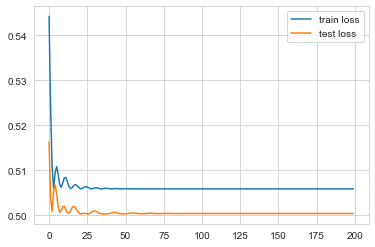

In [14]:
# Plot the train loss and test loss
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()

In [15]:
# 'Wrong' forecast using true targets
validation_target = Y[-N//2:]
validation_predictions = []

# index of first validation input
i = 0

while len(validation_predictions) < len(validation_target):
    input_ = X_test[i].reshape(1, T, 1)
    p = model(input_)[0,0].item() # 1x1 array => scalar
    i += 1
    
    # update the predictions list
    validation_predictions.append(p)

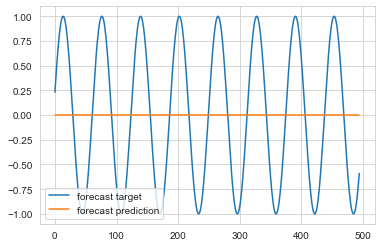

In [16]:
plt.plot(validation_target, label='forecast target')
plt.plot(validation_predictions, label='forecast prediction')
plt.legend()

In [17]:
# Forecast future values
validation_target = Y[-N//2:]
validation_predictions = []

# last train input
# 1-D array of length T
last_x = X_test[0].view(T)

while len(validation_predictions) < len(validation_target):
    input_ = last_x.reshape(1, T, 1)
    p = model(input_)
    
     # update the predictions list
    validation_predictions.append(p[0,0].item())
    
    # make the new input
    last_x = torch.cat((last_x[1:], p[0]))
    #last_x = torch.cat((last_x[1:].reshape(-1,1), p[0].reshape(1,1)))

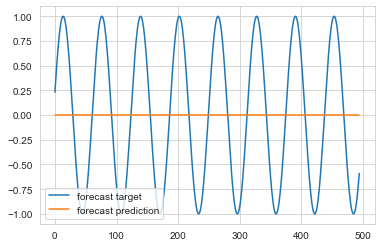

In [18]:
plt.plot(validation_target, label='forecast target')
plt.plot(validation_predictions, label='forecast prediction')
plt.legend()